# Methanol Spray Flame Combustion

![A black-and-white diagram showing the experimental setup used to make measurments of the Methanol Sray Flame](experimental-setup.png)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn

In [2]:
df = pd.read_csv("data-a4.csv"); df

,radius,v-radial,v-axial,v-tangential,v-magnitude
0,19.580,0.152690,1.56420,1.258400,2.01340
1,20.426,0.207950,1.74720,1.460600,2.28680
2,21.272,0.233860,1.94940,1.713300,2.60580
3,22.118,0.240770,2.15350,2.000800,2.94940
4,22.964,0.231950,2.35300,2.354400,3.33670
5,23.810,0.232230,2.53960,2.637500,3.66880
6,24.656,0.223650,2.69420,2.825000,3.91010
7,25.502,0.214610,2.75380,2.865500,3.98000
8,26.348,0.210270,2.78590,2.878700,4.01160
9,27.193,0.213610,2.80970,2.880700,4.02970


<Axes: ylabel='Frequency'>

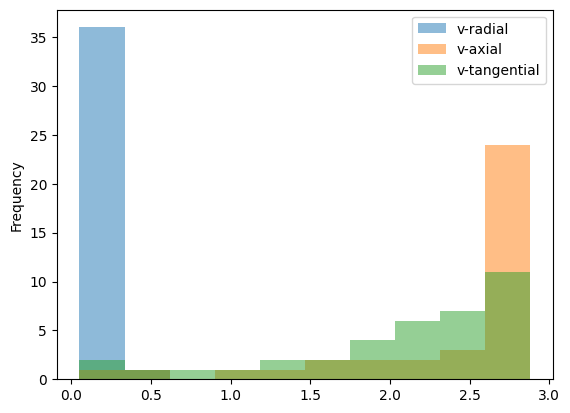

In [3]:
df.plot.hist(column=["v-radial", "v-axial", "v-tangential"], bins=10, alpha=0.5)

<Axes: xlabel='radius'>

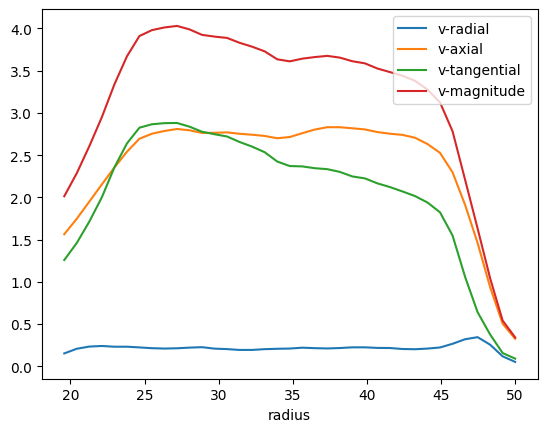

In [4]:
df.plot(x="radius", y=["v-radial", "v-axial", "v-tangential", "v-magnitude"])

In [5]:
radius       = torch.from_numpy(df["radius"].to_numpy())
v_radial     = torch.from_numpy(df["v-radial"].to_numpy())
v_axial      = torch.from_numpy(df["v-axial"].to_numpy())
v_tangential = torch.from_numpy(df["v-tangential"].to_numpy())
v_magnitude  = torch.from_numpy(df["v-magnitude"].to_numpy())

In [6]:
X = torch.cat((radius.unsqueeze(dim=1), v_magnitude.unsqueeze(dim=1)), 1)
Y = torch.cat((v_radial.unsqueeze(dim=1), v_axial.unsqueeze(dim=1), v_tangential.unsqueeze(dim=1)), 1)

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2,
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

/home/maxim/tmp/ipykernel_31227/1578779746.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.float32)
/home/maxim/tmp/ipykernel_31227/1578779746.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.float32)


In [8]:
# Two layer nn with nn.Sequential
model_1 = nn.Sequential(
    #our input is a vector, so 1 diminsion.
    nn.Linear(in_features=2, out_features=32,),
    nn.RReLU(),

    #hidden layer with 32 nodes
    nn.Linear(in_features=32, out_features=16, ),
    nn.RReLU(),

    #moves to hidden layer with 16 nodes
    nn.Linear(in_features=16, out_features=8, ),
    nn.RReLU(),

    #hidden layer with 8 nodes
    nn.Linear(in_features=8, out_features=4, ),
    nn.RReLU(),

    #hidden layer with 4 nodes
    nn.Linear(in_features=4, out_features=3, ),
    #outputs a vector of predicted weights
)

In [9]:
# Create a loss function
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.0001) #this is how fast it optimizes; smaller is slower, but more consistent

In [10]:
# Set the number of epochs; this is how many times we update our model
epochs = 2000

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    model_1.train()

    # 1. Forward pass; makes predictions
    y_pred = model_1(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred.squeeze(), Y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_1.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = model_1(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, Y_test)

    # Print out what's happening
    if epoch % 200 == 0: #prints every 200 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 3.72484, Test loss: 3.54105
Epoch: 200 | Train loss: 3.55778, Test loss: 3.38383
Epoch: 400 | Train loss: 3.39719, Test loss: 3.23301
Epoch: 600 | Train loss: 3.24332, Test loss: 3.08737
Epoch: 800 | Train loss: 3.09131, Test loss: 2.94592
Epoch: 1000 | Train loss: 2.94133, Test loss: 2.80724
Epoch: 1200 | Train loss: 2.80076, Test loss: 2.67198
Epoch: 1400 | Train loss: 2.65639, Test loss: 2.54039
Epoch: 1600 | Train loss: 2.52257, Test loss: 2.41020
Epoch: 1800 | Train loss: 2.37732, Test loss: 2.28023


In [11]:
# Turn on evaluation mode
model_1.eval()

# Make predictions (inference)
with torch.inference_mode():
    Y_preds = model_1(X_test)

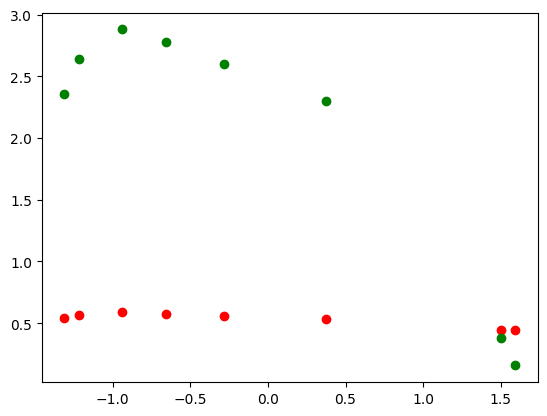

In [16]:
# plt.scatter(X_test.detach().numpy()[:, 0], Y_preds.detach().numpy()[:, 0])
# plt.scatter(X_test.detach().numpy()[:, 0], Y_test.detach().numpy()[:, 0])

plt.scatter(X_test.detach().numpy()[:, 0], Y_preds.detach().numpy()[:, 2], color="red")
plt.scatter(X_test.detach().numpy()[:, 0], Y_test.detach().numpy()[:, 2], color="green")

# #plots predictions--remember, our model has never seen X_test
# plt.scatter(X_test.detach().numpy(),y_preds.detach().numpy())

# #plots test data
# plt.scatter(X_test.detach().numpy(),y_test.detach().numpy())

## Bibliography

- The paper that explains the dataset: https://doi.org/10.1016/S0010-2180(01)00374-1
- The dataset: https://webbook.nist.gov/chemistry/special/spray-combust/